[Inhaltsverzeichnis](../AP4.ipynb) | [ < zurück ](wohin?)|  [ > next](wohin?)

## 4.3.1  Szenarien stündlich aufgelöst




FLUCCOplus Setup

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload

In [2]:
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
%matplotlib inline
from FLUCCOplus.notebooks import *



FLUCCOplus.config  loaded!
FLUCCOplus.notebooks loaded!


### Scenario Überblick
Zuerst werden alle Szenarien aus Excel eingelesen und dargestellt

In [4]:
import FLUCCOplus.scenarios as scens

In [5]:
sc = scens.all()
print(*[i+k for i,k in zip([i for i in sc.index], ["\n"]*len(sc.index))])

EM2018
 EM2019
 E-Control 2019
 Energie und Klimazukunft 2030 (Veigl17)
 Erneuerbare Energie 2030 (UBA16)
 WEM 2030 (UBA17)
 Transition 2030 (UBA17)
 Energie und Klimazukunft 2050 (Veigl17)
 Erneuerbare Energie 2050 (UBA16)
 WEM 2050 (UBA17)
 Transition 2050 (UBA17)
 100% Erneuerbare Deckung 2050 (FLUCCO+)
 100% Erneuerbare Deckung 2050 inkl Methan (FLUCCO+)



C:\Users\Simon Schneider\anaconda\envs\FLUCCOplus\lib\site-packages\openpyxl\worksheet\_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\Simon Schneider\anaconda\envs\FLUCCOplus\lib\site-packages\openpyxl\worksheet\_reader.py:308: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


## Creating a Scenario object



In [6]:
from FLUCCOplus.scenarios import Scenario
 

### EM Base data
Select an electricity map year


In [7]:
em_year = 2018 # 2015, 2016, 2017, 2018 # 2019? nicht? # Es fehlen einige Daten im 2019... soll ma mit Null to fill? aber das wird dann zu falschen Ergebnissen führen, oder?

Select an available Scenario ``name`` 

In [8]:
#name = "EM2018"
#name = "EM2019"                                                  
#name = "E-Control 2019"                                          
#name = "Energie und Klimazukunft 2030 (Veigl17)"                 
#name = "Erneuerbare Energie 2030 (UBA16)"                        
#name = "WEM 2030 (UBA17)"                                        
#name = "Transition 2030 (UBA17)"                                 
#name = "Energie und Klimazukunft 2050 (Veigl17)"                
#name = "Erneuerbare Energie 2050 (UBA16)"                        
#name = "WEM 2050 (UBA17)"                                       
name = "Transition 2050 (UBA17)"                                 
#name = "100% Erneuerbare Deckung 2050 (FLUCCO+)"                 
#name = "100% Erneuerbare Deckung 2050 inkl Methan (FLUCCO+)" 

Create the scenario

C:\Users\Simon Schneider\anaconda\envs\FLUCCOplus\lib\site-packages\openpyxl\worksheet\_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\Simon Schneider\anaconda\envs\FLUCCOplus\lib\site-packages\openpyxl\worksheet\_reader.py:308: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


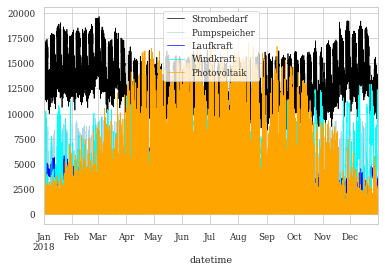

In [9]:
import FLUCCOplus.electricitymap as elmap

s = Scenario(  
    name = name, # can be anything
    scenario = name, # must be a scenario name
    em_base = {"year": em_year,
               "df": elmap.fetch(year=em_year)})
s
s.plot()

In [10]:
import os
if not os.path.exists("..\data\Plots"):
        os.makedirs("..\data\Plots")

[Text(0.5, 1.0, 'Jahresverlauf 2018'),
 Text(0.5, 0, 'Zeit'),
 Text(0, 0.5, 'Energie [GWh]')]

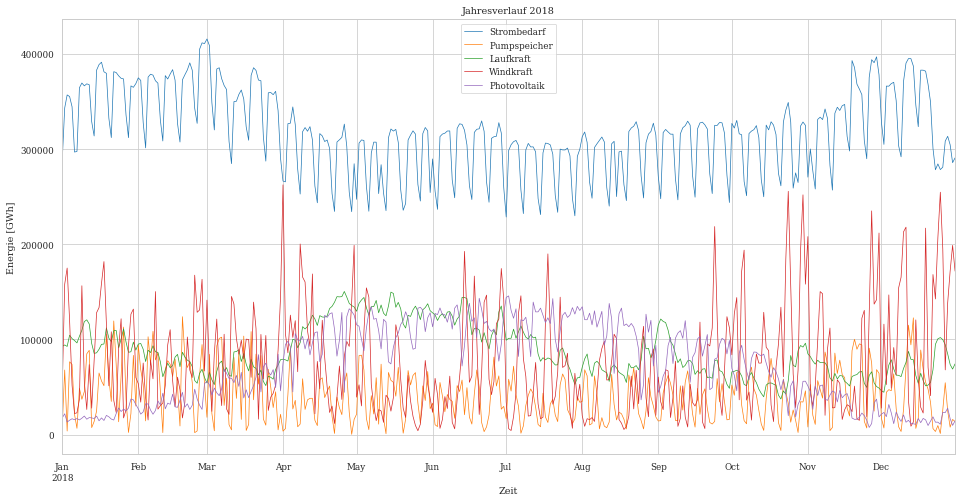

In [11]:
# einheitlichen Plot#
# RES, Energieverbrauch
df = s.TSD

df.resample("D").sum().plot(figsize=(16,8)).set(title="Jahresverlauf " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]")

In [107]:
df.columns

Index(['Strombedarf', 'Pumpspeicher', 'Laufkraft', 'Windkraft', 'Photovoltaik',
       'Non_volatiles', 'RES', 'RESohneWind', 'WindkraftUeSch',
       'WindkraftLast', 'Wind_rel', 'PVUeSch', 'PVLast', 'PV_rel',
       'Residual_ohne_Wind', 'Zero', 'Wind_useful', 'Wind_Nennleistung'],
      dtype='object')

In [11]:
Nicht volatile Energieträger (**ET**), wie Pumpspeicher und Laufkraft werden summiert.

In [11]:
df["Non_volatiles"] = df.Pumpspeicher + df.Laufkraft
df["RES"] = df.Laufkraft + df.Windkraft + df.Photovoltaik + df.Pumpspeicher
df["RESohneWind"] = df.Laufkraft + df.Photovoltaik + df.Pumpspeicher

cols = ["Strombedarf",
#        "RESohneWind",
        "RES",
#        "Non Volatiles",
        #"Windkraft"
         ]

df[cols].iloc[0:600,:].plot(figsize=(16,8))

<AxesSubplot:xlabel='datetime'>

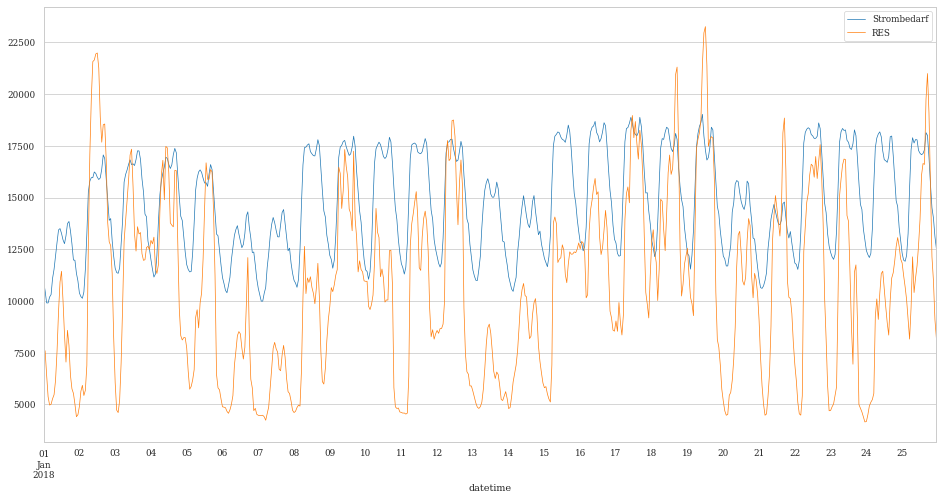

In [12]:
# Wind
Es wird analysiert, wenn Windkraft in der Reihenfolge als letzte Energiequelle verwendet wird.
Der Überschuss vom Windkraft wird durch den Strombedarf und die Erzeugung von den verschiedenen Energieträgern bestimmt. Wenn
$$ Nicht Volatile + PV >= Strombedarf $$
wird bedeuten, dass die alle Energie vom Windkraft Überschuss sind. In dem Fall wenn
$$ Nicht Volatile + PV < Strombedarf $$ und $$ RES >= Strombedarf $$
wird der Überschuss
$$ RES - Strombedarf $$
berechnet. In den anderen Fällen gibt es keinen Überschuss.
"WindkraftLast" wird für jede Stunde wie folgt berechnet: $$ Strombedarf - RES + Windkraft $$



df["WindkraftUeSch"] = 0    # Überschuss
df["WindkraftLast"] = 0    # Direktverbrauch
for t in range(8760):
    if (df.Photovoltaik[t] + df.Non_volatiles[t]) >= df.Strombedarf[t]:
        df.WindkraftUeSch[t] = df.Windkraft[t]
    elif (df.Photovoltaik[t] + df.Non_volatiles[t]) < df.Strombedarf[t]:
        if df.RES[t] < df.Strombedarf[t]:
                df.WindkraftUeSch[t] = 0
        else:
            df.WindkraftUeSch[t] = df.RES[t] - df.Strombedarf[t]

    if df.RES[t] > df.Strombedarf[t]:
        df.WindkraftLast[t] = df.Strombedarf[t] - df.RES[t] + df.Windkraft[t]
cols_wind = ["Strombedarf",
        "RES",
        "WindkraftLast",
        "WindkraftUeSch"
             ]

df[cols_wind].iloc[600:1000,:].plot(figsize=(12,7)).set(title="Windlast " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]")
plt.axhline(y=df.Windkraft.max()*0.4)
#df[cols_wind].resample("D").sum().plot(figsize=(12,7))


<ipython-input-13-d189b6dfbc6c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.WindkraftUeSch[t] = 0
<ipython-input-13-d189b6dfbc6c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.WindkraftUeSch[t] = df.RES[t] - df.Strombedarf[t]
<ipython-input-13-d189b6dfbc6c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.WindkraftLast[t] = df.Strombedarf[t] - df.RES[t] + df.Windkraft[t]
<ipython-input-13-d189b6dfbc6c>:5: SettingWith

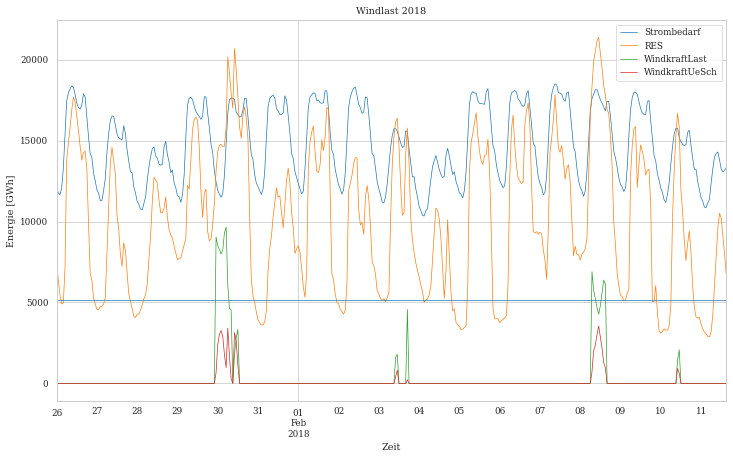

In [13]:
"Wind_rel" ist das Verhältnis die vorher berechnete WindkraftLast zur installierten Windkraftleistung (maximale Erzeugungswert der Windkraftdaten):
$$ Wind_r_e_l = WindkraftLast / Windkraft_m_a_x $$


df["Residual_ohne_Wind"] = df.Strombedarf - df.Photovoltaik - df.Non_volatiles #(non  volatiles = pump und lauf)
df["Zero"] = 0
df["Wind_useful"] = (df[["Windkraft", "Residual_ohne_Wind"]]).min(axis=1).clip(0, None)
df[["Wind_useful", "Windkraft","Residual_ohne_Wind"]].iloc[1:200,:].plot()

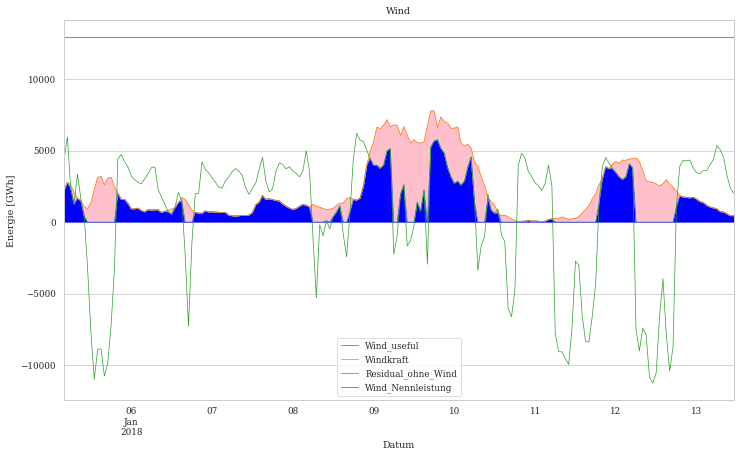

In [134]:
df["Wind_Nennleistung"] = df.Windkraft.max()
df[["Wind_useful", "Windkraft","Residual_ohne_Wind","Wind_Nennleistung"]].iloc[100:300,:].plot(figsize=(12,7)).set(title="Wind", xlabel="Datum", ylabel="Energie [GWh]")
fill5 = plt.fill_between(df.index, df["Zero"], df["Wind_useful"], color='blue')
fill5 = plt.fill_between(df.index, df["Wind_useful"], df["Windkraft"], color='pink')

<AxesSubplot:xlabel='datetime'>

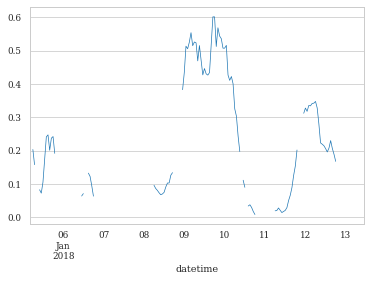

In [135]:
df["Wind_rel"] = df.Windkraft / df.Windkraft.max() # in % der Nennleistung
df_windrel= df.Wind_rel.where(df.Windkraft > df.Wind_useful)#.plot()
df_windrel.iloc[100:300].plot()  # zeitpunkte mit "freigabesignal, weil wind > res_ohne_wind



<AxesSubplot:xlabel='datetime'>

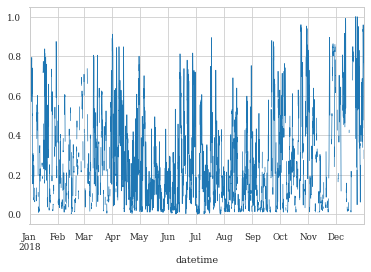

6009

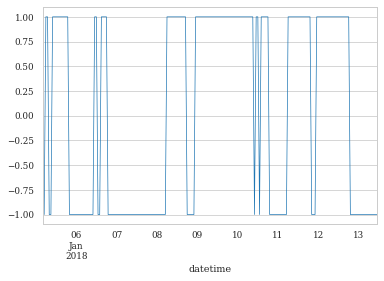

In [136]:
real_signal = df_windrel.map(lambda x: 1 if x > 0 else -1)
real_signal.iloc[100:300].plot()
real_signal.where(real_signal==1).count()


df_windrel.mean()

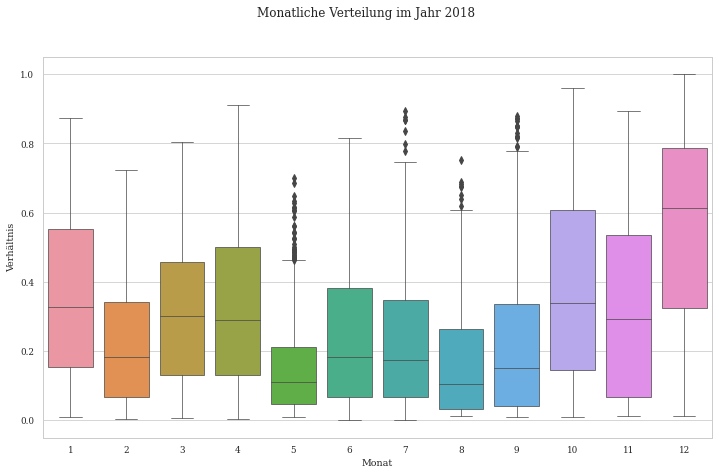

In [118]:
import seaborn as sns
fig, ax = plt.subplots()
sns.boxplot(x=df_windrel.index.month, y=df_windrel, orient="v", ax=ax).set(xlabel='Monat', ylabel="Verhältnis")
fig.set_size_inches(12, 7)
fig.suptitle(f'Monatliche Verteilung im Jahr {em_year}', fontsize=12)
fig.savefig(f"../data/Plots/Monatlich_wind_{em_year}.png", dpi=300, bbox_inches='tight')

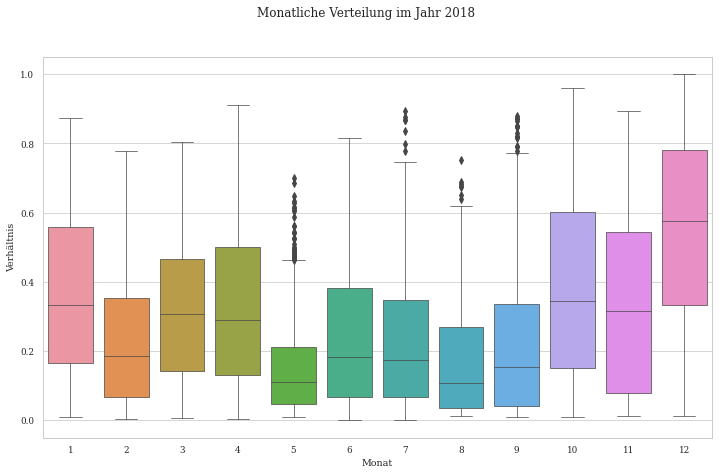

In [15]:
#fig, ax = plt.subplots(figsize=(12,7))
#col= [
#    "Non_volatiles",
#    "Windkraft",
#    "Photovoltaik",
#    "WindkraftUeSch"
#    ]
#df[col][["Non_volatiles", "Windkraft", "Photovoltaik", "WindkraftUeSch"]].resample("M").sum().plot(kind="bar", color=["g", "c", "y", "blue"], stacked=True, ax = ax).set(ylabel="Stunden")
#for p in ax.patches:
#     ax.annotate("{:.1f}%" .format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() -5), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
#df["Strombedarf"].resample("M").sum().plot()
# noch nicht richtig...

In [16]:
## Sommerwoche Wind
Es wird hier abgebildet, wie eine typische Sommerwoche aussieht, wenn die von der Windkraftanlage stammende Energie in der Reihenfolge als letzte Energiequelle verwendet wird.

summerweek_start = "2018-07-20"
summerweek_stop = "2018-07-27"
winterweek_start = "2018-01-20"
winterweek_stop = "2018-01-27"

In [17]:
max_score_wind = max(max(df[cols_wind].loc[summerweek_start:summerweek_stop].max()), max(df[cols_wind].loc[winterweek_start:winterweek_stop].max()))
ax_scale_wind = 0, (max_score_wind+1000)

In [18]:
fig, ax = plt.subplots()
df["Strombedarf"].loc[summerweek_start:summerweek_stop].plot(figsize=(12,7)).set(title="Sommerwoche Wind " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]", ylim=ax_scale_wind)
fill1 = plt.fill_between(df.index, df["Non_volatiles"], color="g")
fill2 = plt.fill_between(df.index, df["RESohneWind"], df["Non_volatiles"], color='y')
fill3 = plt.fill_between(df.index, df["RES"], df["RESohneWind"], color="c")
fill4 = plt.fill_between(df.index, df["RESohneWind"], df["Strombedarf"], where=df["RESohneWind"]>df["Strombedarf"], color="orange")
fill5 = plt.fill_between(df.index, df["RES"]-df["WindkraftUeSch"], df["RES"], where=df["WindkraftUeSch"]>0, color='blue')
plt.legend([fill5, fill4, fill3, fill2, fill1], ["Windkraft Überschuss", "PV Überschuss", "Windkraft","PV","Nicht volatile"])
fig.savefig(f"../data/Plots/Wind_Sommerwoche_{em_year}.png", dpi=300, bbox_inches='tight')

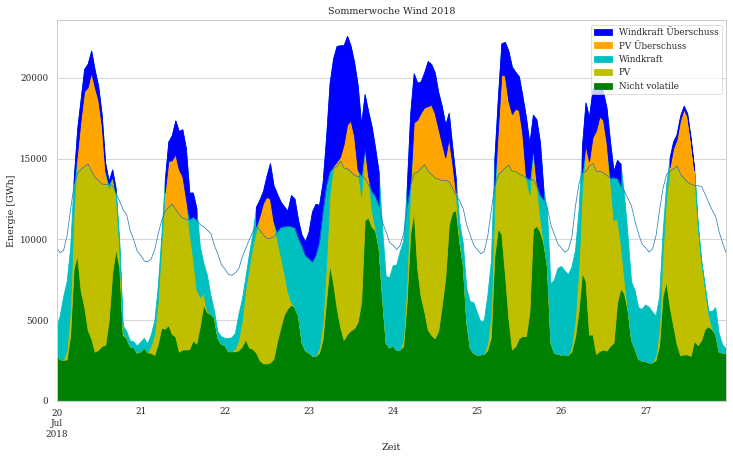

In [19]:
fig, ax = plt.subplots()
df["WindkraftLast"].loc[summerweek_start:summerweek_stop].plot(figsize=(12,7)).set(title="Sommerwoche Wind " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]", ylim=ax_scale_wind)
fill5 = plt.fill_between(df.index, df["Windkraft"], df["Windkraft"]+df["WindkraftUeSch"], where=df["WindkraftUeSch"]>0, color='blue')

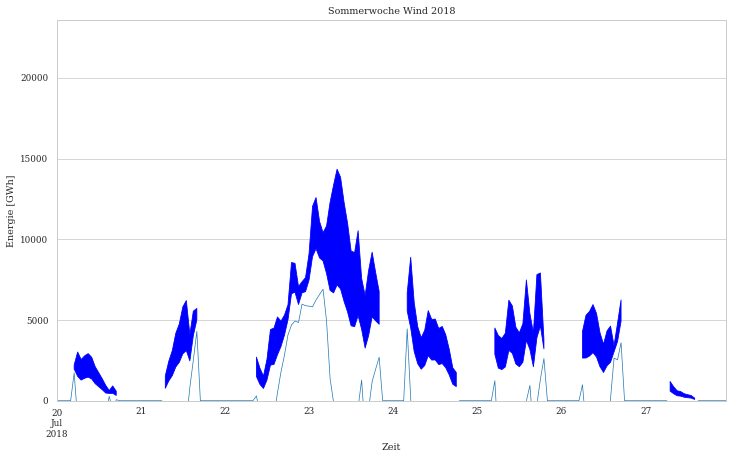

In [56]:
## Winterwoche Wind
Es wird hier abgebildet, wie eine typische Winterwoche aussieht, wenn die von der Windkraftanlage stammende Energie in der Reihenfolge als letzte Energiequelle verwendet wird.

<AxesSubplot:xlabel='datetime'>

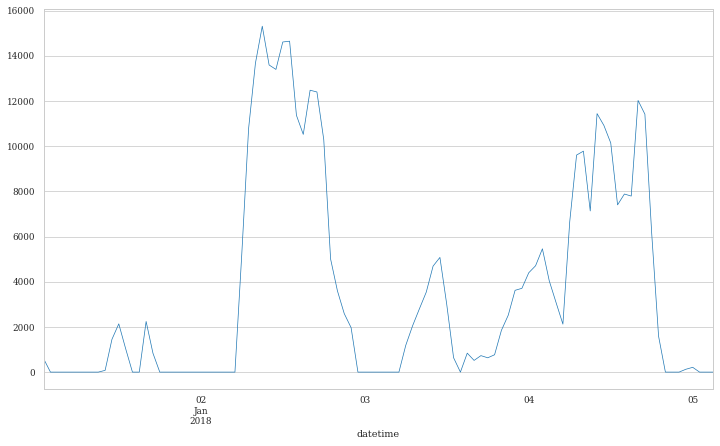

In [81]:
fig, ax = plt.subplots()
df["Strombedarf"].loc[winterweek_start:winterweek_stop].plot(figsize=(12,7)).set(title="Winterwoche Wind " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]", ylim=ax_scale_wind)
fill1 = plt.fill_between(df.index, df["Non_volatiles"], color="g")
fill2 = plt.fill_between(df.index, df["RESohneWind"], df["Non_volatiles"], color='y')
fill3 = plt.fill_between(df.index, df["RES"], df["RESohneWind"], color="c")
fill4 = plt.fill_between(df.index, df["RESohneWind"], df["Strombedarf"], where=df["RESohneWind"]>df["Strombedarf"], color="orange")
fill5 = plt.fill_between(df.index, df["RES"]-df["WindkraftUeSch"], df["RES"], where=df["WindkraftUeSch"]>0, color='blue')
plt.legend([fill5, fill4, fill3, fill2, fill1], ["Windkraft Überschuss", "PV Überschuss", "Windkraft","PV","Nicht volatile"])
fig.savefig(f"../data/Plots/Wind_Winterwoche_{em_year}.png", dpi=300, bbox_inches='tight')

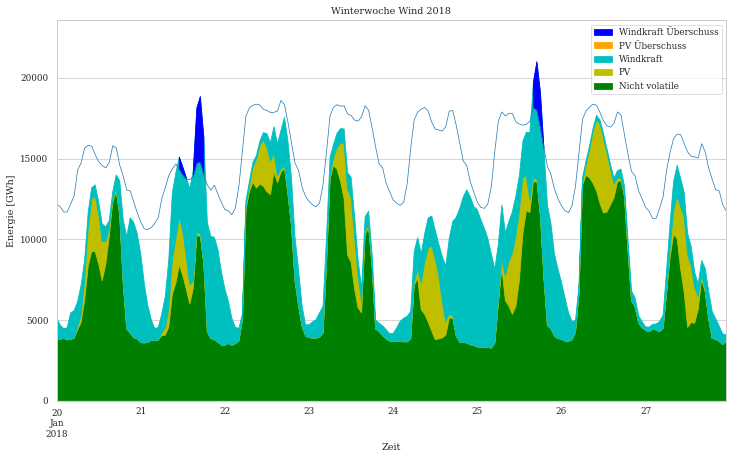

In [21]:
Hier wird analysiert, wie viele Signale und Nicht-Signale, beziehungsweise durchschnittliche Signal- und Nicht-Signal-Dauer werden in dem Jahr bei einem "cut off" von 40% geben.

cut = 0.4
df_sign_wind = pd.DataFrame()


In [138]:

for c in df.columns:
    df_sign_wind[c] = df[c].map(lambda x: -1 if x < cut else 1)

df_sign_wind

,Strombedarf,Pumpspeicher,Laufkraft,Windkraft,Photovoltaik,Non_volatiles,RES,RESohneWind,WindkraftUeSch,WindkraftLast,Wind_rel,PVUeSch,PVLast,PV_rel,Residual_ohne_Wind,Zero,Wind_useful,Wind_Nennleistung
datetime,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,1,1,1,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1
2018-01-01 01:00:00+00:00,1,-1,1,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1
2018-01-01 02:00:00+00:00,1,-1,1,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1
2018-01-01 03:00:00+00:00,1,-1,1,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1
2018-01-01 04:00:00+00:00,1,-1,1,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+00:00,1,1,1,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1
2018-12-31 20:00:00+00:00,1,1,1,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1
2018-12-31 21:00:00+00:00,1,1,1,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1


In [22]:
df_step_wind = pd.DataFrame()
df_not_wind = pd.DataFrame()

#fig, ax = plt.subplots()
for c in df_sign_wind.columns:
    df_step_wind[c] =  df_sign_wind[c].shift(1).ne(df_sign_wind[c]).where(df_sign_wind[c]==1).cumsum()
    df_not_wind[c] =  df_sign_wind[c].shift(1).ne(df_sign_wind[c]).where(df_sign_wind[c]==-1).cumsum()
df_step_wind.iloc[0,:] = 0


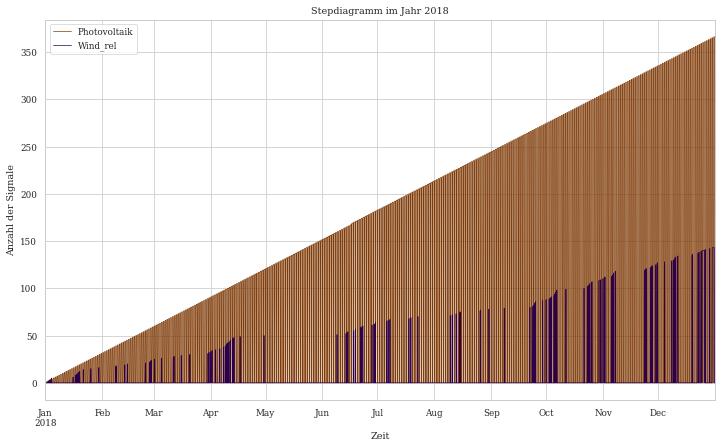

In [141]:
colsstep_wind = [
        "Photovoltaik",
        #"Non Volatiles",
        #"WindkraftLast",
        "Wind_rel",
        ]

fig, ax = plt.subplots()
df_step_wind[colsstep_wind].plot(figsize=(12,7), cmap="PuOr", grid=True, ax=ax).set(title=f"Stepdiagramm im Jahr {em_year}", xlabel="Zeit", ylabel="Anzahl der Signale")

fig.savefig(f"../data/Plots/Stepdiagramm_wind_{em_year}_{cut}.png", dpi=300, bbox_inches='tight')

In [142]:
df_step_wind.fillna(0, inplace=True)
df_not_wind.fillna(0, inplace=True)

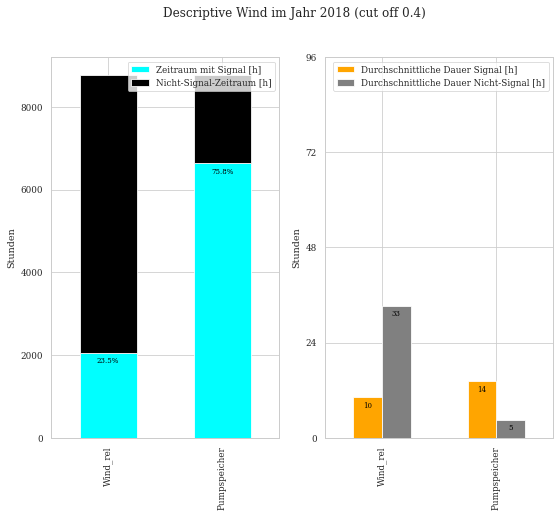

In [147]:
from utils import plot_signal_bars

fig, ax = plot_signal_bars(df_sign_wind, ["Wind_rel", "Pumpspeicher"], ytick_average_max=97)
fig.suptitle(f'Descriptive Wind im Jahr {em_year} (cut off {cut})', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_wind_{em_year}_{cut}.png", dpi=300, bbox_inches='tight')

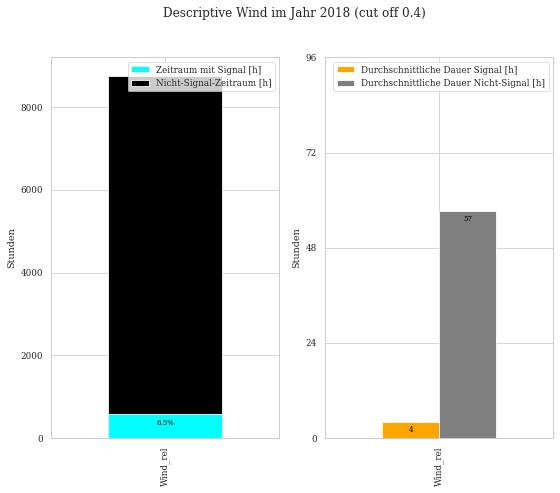

In [27]:
fig, ax = plt.subplots(1,2, figsize=(9,7))
desc_wind.loc[colsstep_wind][["Zeitraum mit Signal [h]","Nicht-Signal-Zeitraum [h]"]]\
    .plot(kind="bar",color=["cyan", "black"], stacked=True, ax = ax[0]).set(ylabel="Stunden")
desc_wind.loc[colsstep_wind][["Durchschnittliche Dauer Signal [h]","Durchschnittliche Dauer Nicht-Signal [h]"]]\
    .plot(kind="bar",color=["orange", "grey"], stacked=False, ax = ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
     ax[0].annotate("{:.1f}%" .format(p.get_height()*100/8760), (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() -5), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
      ax[1].annotate("{:.0f}" .format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive Wind im Jahr {em_year} (cut off {cut})', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_wind_{em_year}_{cut}.png", dpi=300, bbox_inches='tight')

## Sommer - Winter - Vergleich
Es werden die Sommer- und Wintermonate getrennt verglichen.
Wintermonate: Januar, Februar, März, Oktober, November, Dezember.
Sommermonate: April, Mai, Juni, Juli, August, September.

In [28]:
df_wind_sign_s = df_sign_wind.loc[(df_sign_wind.index.month >= 4) & (df_sign_wind.index.month < 10)]
df_wind_sign_w = df_sign_wind.loc[(df_sign_wind.index.month >= 10) | (df_sign_wind.index.month < 4)]

### Winter

In [29]:
df_wind_step_w = pd.DataFrame()
df_wind_not_w = pd.DataFrame()

for c in df_wind_sign_w.columns:
    df_wind_step_w[c] =  df_wind_sign_w[c].shift(1).ne(df_wind_sign_w[c]).where(df_wind_sign_w[c]==1).cumsum()
    df_wind_not_w[c] =  df_wind_sign_w[c].shift(1).ne(df_wind_sign_w[c]).where(df_wind_sign_w[c]==-1).cumsum()
df_wind_step_w.iloc[0,:] = 0

In [30]:
desc_wind_w = pd.DataFrame()
desc_wind_w["Zeitraum mit Signal [h]"] = df_wind_sign_w.where(df_wind_sign_w>0).sum()
desc_wind_w["Nicht-Signal-Zeitraum [h]"] = len(df_wind_sign_w) - desc_wind_w["Zeitraum mit Signal [h]"]
desc_wind_w["Anzahl Signal-Perioden"] = df_wind_step_w.max()
desc_wind_w["Durchschnittliche Dauer Signal [h]"] = (desc_wind_w["Zeitraum mit Signal [h]"]/desc_wind_w["Anzahl Signal-Perioden"])
desc_wind_w["Durchschnittliche Dauer Nicht-Signal [h]"] = desc_wind_w["Nicht-Signal-Zeitraum [h]"]/desc_wind_w["Anzahl Signal-Perioden"]


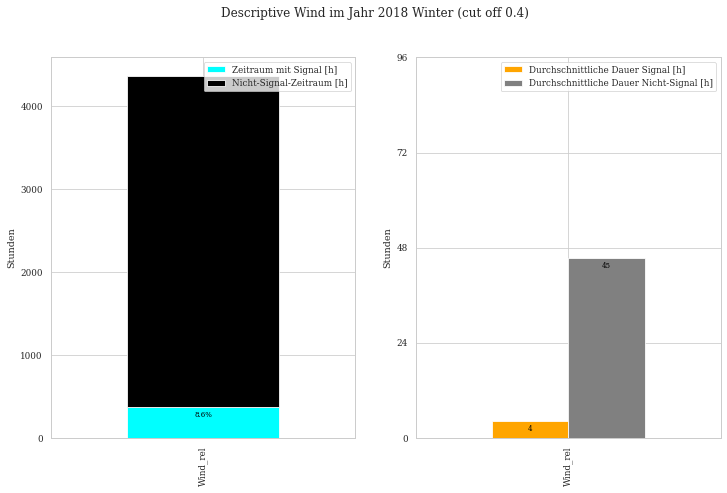

In [31]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
desc_wind_w.loc[colsstep_wind][["Zeitraum mit Signal [h]","Nicht-Signal-Zeitraum [h]"]]\
    .plot(kind="bar",color=["cyan", "black"], stacked=True, ax = ax[0]).set(ylabel="Stunden")
desc_wind_w.loc[colsstep_wind][["Durchschnittliche Dauer Signal [h]","Durchschnittliche Dauer Nicht-Signal [h]"]]\
    .plot(kind="bar",color=["orange", "grey"], stacked=False, ax = ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
     ax[0].annotate("{:.1f}%" .format(p.get_height()*100/len(df_wind_sign_w)), (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() -5), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
      ax[1].annotate("{:.0f}" .format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive Wind im Jahr {em_year} Winter (cut off {cut})', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_wind_{em_year}_winter_{cut}.png", dpi=300, bbox_inches='tight')

In [32]:
df_wind_step_s = pd.DataFrame()
df_wind_not_s = pd.DataFrame()

for c in df_wind_sign_s.columns:
    df_wind_step_s[c] =  df_wind_sign_s[c].shift(1).ne(df_wind_sign_s[c]).where(df_wind_sign_s[c]==1).cumsum()
    df_wind_not_s[c] =  df_wind_sign_s[c].shift(1).ne(df_wind_sign_s[c]).where(df_wind_sign_s[c]==-1).cumsum()
df_wind_step_s.iloc[0,:] = 0

In [33]:
desc_wind_s = pd.DataFrame()
desc_wind_s["Zeitraum mit Signal [h]"] = df_wind_sign_s.where(df_wind_sign_s>0).sum()
desc_wind_s["Nicht-Signal-Zeitraum [h]"] = len(df_wind_sign_s) - desc_wind_s["Zeitraum mit Signal [h]"]
desc_wind_s["Anzahl Signal-Perioden"] = df_wind_step_s.max()
desc_wind_s["Durchschnittliche Dauer Signal [h]"] = (desc_wind_s["Zeitraum mit Signal [h]"]/desc_wind_s["Anzahl Signal-Perioden"])
desc_wind_s["Durchschnittliche Dauer Nicht-Signal [h]"] = desc_wind_s["Nicht-Signal-Zeitraum [h]"]/desc_wind_s["Anzahl Signal-Perioden"]

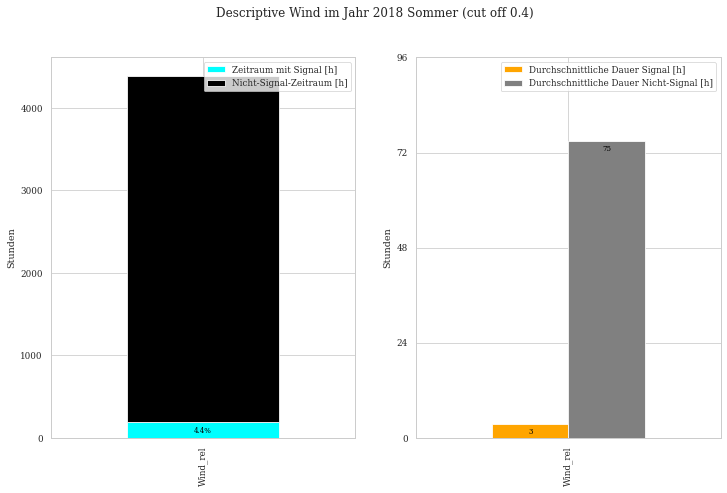

In [34]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
desc_wind_s.loc[colsstep_wind][["Zeitraum mit Signal [h]","Nicht-Signal-Zeitraum [h]"]]\
    .plot(kind="bar",color=["cyan", "black"], stacked=True, ax = ax[0]).set(ylabel="Stunden")
desc_wind_s.loc[colsstep_wind][["Durchschnittliche Dauer Signal [h]","Durchschnittliche Dauer Nicht-Signal [h]"]]\
    .plot(kind="bar",color=["orange", "grey"], stacked=False, ax = ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
     ax[0].annotate("{:.1f}%" .format(p.get_height()*100/len(df_wind_sign_s)), (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() -5), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
      ax[1].annotate("{:.0f}" .format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive Wind im Jahr {em_year} Sommer (cut off {cut})', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_wind_{em_year}_sommer_{cut}.png", dpi=300, bbox_inches='tight')

# PV first
Es wird analysiert, wenn Photovoltaik in der Reihenfolge als letzte Energiequelle verwendet wird.
Der Überschuss vom PV wird durch den Strombedarf und die Erzeugung von den verschiedenen Energieträgern bestimmt. Wenn
$$ Nicht Volatile + Windkraft >= Strombedarf $$
wird bedeuten, dass die alle Energie vom PV Überschuss sind. In dem Fall, wenn
$$ Nicht Volatile + Windkraft < Strombedarf $$ und $$ RES >= Strombedarf $$
wird der Überschuss
$$ RES - Strombedarf $$
berechnet. In den anderen Fällen gibt es keinen Überschuss.
"PVLast" wird für jede Stunde wie folgt berechnet: $$ Strombedarf - RES + PV $$

<ipython-input-35-887c8556211a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.PVUeSch[t] = 0
<ipython-input-35-887c8556211a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.PVUeSch[t] = df.Photovoltaik[t]
<ipython-input-35-887c8556211a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.PVLast[t] = df.Strombedarf[t] - df.RES[t] + df.Photovoltaik[t]
<ipython-input-35-887c8556211a>:10: SettingWithCopyWarning: 
A value is tryi

[Text(0.5, 1.0, 'PV-last im 2018'),
 Text(0.5, 0, 'Zeit'),
 Text(0, 0.5, 'Energie [GWh]')]

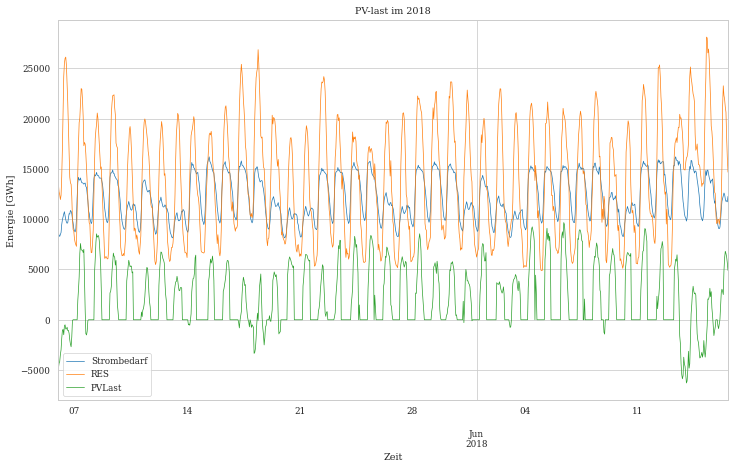

In [35]:
df["PVUeSch"] = 0    # Überschuss
df["PVLast"] = 0    # Direktverbrauch
for t in range(8760):
    if (df.Windkraft[t] + df.Non_volatiles[t]) >= df.Strombedarf[t]:
        df.PVUeSch[t] = df.Photovoltaik[t]
    elif (df.Windkraft[t] + df.Non_volatiles[t]) < df.Strombedarf[t]:
        if df.RES[t] < df.Strombedarf[t]:
                df.PVUeSch[t] = 0
        else:
            df.PVUeSch[t] = df.RES[t] - df.Strombedarf[t]

    if df.RES[t] > df.Strombedarf[t]:
        df.PVLast[t] = df.Strombedarf[t] - df.RES[t] + df.Photovoltaik[t]

cols = ["Strombedarf",
        "RES",
        "PVLast"]

df[cols].iloc[3000:4000,:].plot(figsize=(12,7)).set(title="PV-last im " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]")
#plt.axhline(y=df.Photovoltaik.max()*0.4)
#df[cols].resample("D").sum().plot(figsize=(12,7))

"PV_rel" ist das Verhältnis die vorher berechnete PVLast zur installierten PV-Anlagenleistung (maximale Erzeugungswert der Photovoltaikdaten):
$$ PV_r_e_l = PVLast / Phtovoltaik_m_a_x $$

In [36]:
df["PV_rel"] = df.PVLast / df.Photovoltaik.max()
df_PVrel = df.PV_rel.where(df.PV_rel != 0)#.plot()

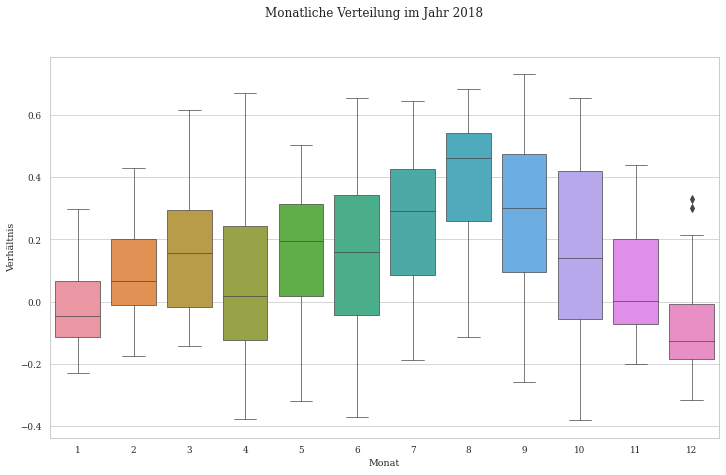

In [37]:
fig, ax = plt.subplots()
sns.boxplot(x=df_PVrel.index.month, y=df_PVrel, orient="v", ax=ax).set(xlabel='Monat', ylabel="Verhältnis")
fig.set_size_inches(12, 7)
fig.suptitle(f'Monatliche Verteilung im Jahr {em_year}', fontsize=12)
fig.savefig(f"../data/Plots/Monatlich_PV_{em_year}.png", dpi=300, bbox_inches='tight')

## Sommerwoche PV
Es wird hier abgebildet, wie eine typische Sommerwoche aussieht, wenn die von der Photovoltaikanlage stammende Energie in der Reihenfolge als letzte Energiequelle verwendet wird.

In [38]:
max_score_PV = max(max(df[cols].loc[summerweek_start:summerweek_stop].max()),
                     max(df[cols].loc[winterweek_start:winterweek_stop].max()))
ax_scale_PV = 0, (max_score_PV + 1000)

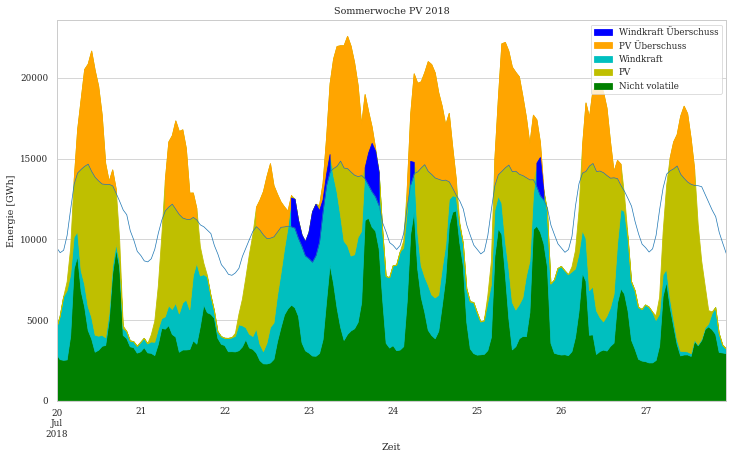

In [39]:
fig, ax = plt.subplots()
df["Strombedarf"].loc[summerweek_start:summerweek_stop].plot(figsize=(12,7)).set(title="Sommerwoche PV " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]", ylim=ax_scale_PV)
fill1 = plt.fill_between(df.index, df["Non_volatiles"], color="g")
fill2 = plt.fill_between(df.index, df["RESohneWind"]-df["Photovoltaik"]+df["Windkraft"], df["Non_volatiles"], color='c')
fill3 = plt.fill_between(df.index, df["RES"]-df["Photovoltaik"], df["RES"], color="y")
fill4 = plt.fill_between(df.index, df["RES"]-df["PVUeSch"], df["RES"], where=df["PVUeSch"]>0, color='orange')
fill5 = plt.fill_between(df.index, df["RES"]-df["Photovoltaik"], df["Strombedarf"], where=df["Non_volatiles"]+df["Windkraft"]>df["Strombedarf"], color="blue")
plt.legend([fill5, fill4, fill2, fill3, fill1], ["Windkraft Überschuss", "PV Überschuss", "Windkraft","PV","Nicht volatile"])
fig.savefig(f"../data/Plots/PV_Sommerwoche_{em_year}.png", dpi=300, bbox_inches='tight')


## Winterwoche PV
Es wird hier abgebildet, wie eine typische Winterwoche aussieht, wenn die von der Photovoltaikanlage stammende Energie in der Reihenfolge als letzte Energiequelle verwendet wird.

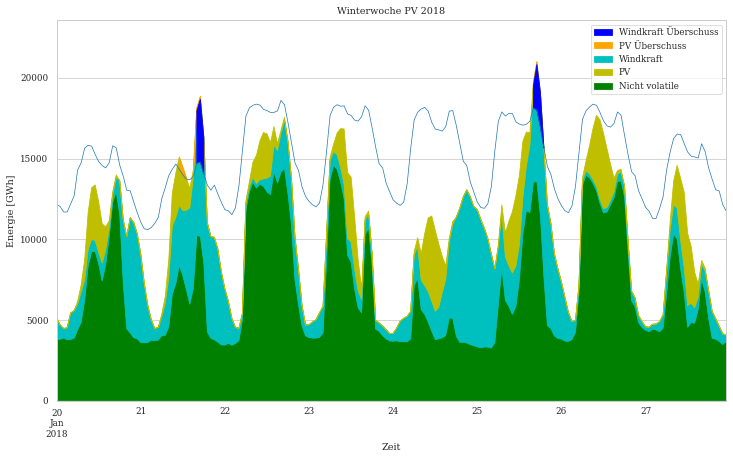

In [40]:
fig, ax = plt.subplots()
df["Strombedarf"].loc[winterweek_start:winterweek_stop].plot(figsize=(12,7)).set(title="Winterwoche PV " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]", ylim=ax_scale_PV)
fill1 = plt.fill_between(df.index, df["Non_volatiles"], color="g")
fill2 = plt.fill_between(df.index, df["RESohneWind"]-df["Photovoltaik"]+df["Windkraft"], df["Non_volatiles"], color='c')
fill3 = plt.fill_between(df.index, df["RES"]-df["Photovoltaik"], df["RES"], color="y")
fill4 = plt.fill_between(df.index, df["RES"]-df["PVUeSch"], df["RES"], where=df["PVUeSch"]>0, color='orange')
fill5 = plt.fill_between(df.index, df["RES"]-df["Photovoltaik"], df["Strombedarf"], where=df["Non_volatiles"]+df["Windkraft"]>df["Strombedarf"], color="blue")
plt.legend([fill5, fill4, fill2, fill3, fill1], ["Windkraft Überschuss", "PV Überschuss", "Windkraft","PV","Nicht volatile"])
fig.savefig(f"../data/Plots/PV_Winterwoche_{em_year}.png", dpi=300, bbox_inches='tight')

Hier wird analysiert, wie viele Signale und Nicht-Signale, beziehungsweise durchschnittliche Signal- und Nicht-Signal-Dauer werden in dem Jahr geben. (ohne "cut off")

In [41]:
df_sign_PV = pd.DataFrame()
for c in df.columns:
    df_sign_PV[c] = df[c].map(lambda x: -1 if x < 0.00001 else 1)

df_step_PV = pd.DataFrame()
df_not_PV = pd.DataFrame()

for c in df_sign_PV.columns:
    df_step_PV[c] = df_sign_PV[c].shift(1).ne(df_sign_PV[c]).where(df_sign_PV[c] == 1).cumsum()
    df_not_PV[c] = df_sign_PV[c].shift(1).ne(df_sign_PV[c]).where(df_sign_PV[c] == -1).cumsum()
df_step_PV.iloc[0, :] = 0

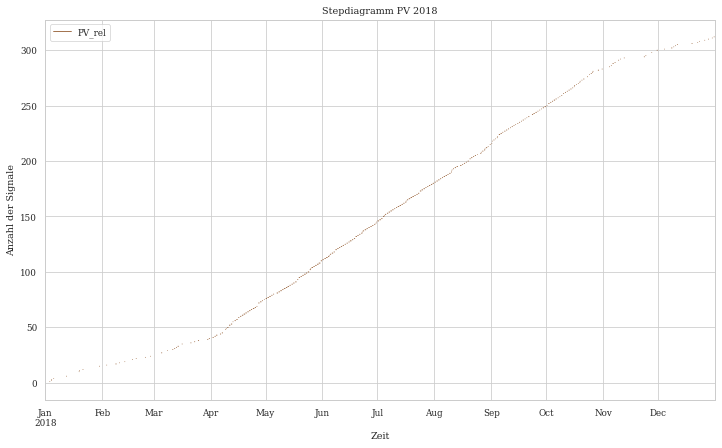

In [42]:
colsstep_PV = [
        #"Photovoltaik",
        #"Non Volatiles",
        #"WindkraftLast",
        #"Wind_rel",
        "PV_rel",
        ]

fig, ax = plt.subplots()
df_step_PV[colsstep_PV].plot(figsize=(12,7), cmap="PuOr", grid=True, ax=ax).set(title=f"Stepdiagramm PV {em_year}", xlabel="Zeit", ylabel="Anzahl der Signale")

fig.savefig(f"../data/Plots/Stepdiagramm_PV_{em_year}.png", dpi=300, bbox_inches='tight')

In [43]:
df_step_PV.fillna(0, inplace=True)
df_not_PV.fillna(0, inplace=True)
desc_PV = pd.DataFrame()
desc_PV["Zeitraum mit Signal [h]"] = df_sign_PV.where(df_sign_PV > 0).sum()
desc_PV["Nicht-Signal-Zeitraum [h]"] = 8760 - desc_PV["Zeitraum mit Signal [h]"]
desc_PV["Anzahl Signal-Perioden"] = df_step_PV.max()
desc_PV["Durchschnittliche Dauer Signal [h]"] = (desc_PV["Zeitraum mit Signal [h]"] / desc_PV["Anzahl Signal-Perioden"])
desc_PV["Durchschnittliche Dauer Nicht-Signal [h]"] = desc_PV["Nicht-Signal-Zeitraum [h]"] / desc_PV["Anzahl Signal-Perioden"]


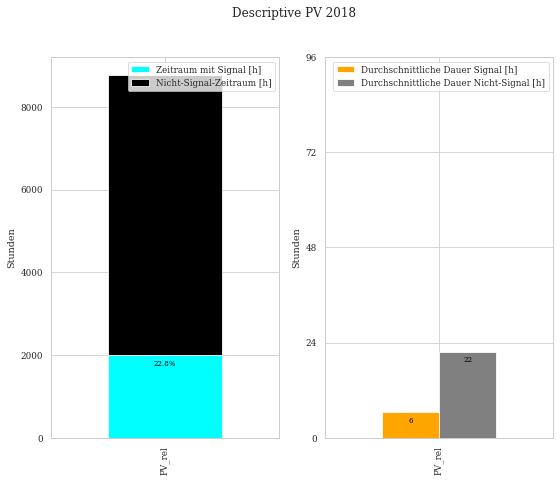

In [44]:
fig, ax = plt.subplots(1,2, figsize=(9,7))
desc_PV.loc[colsstep_PV][["Zeitraum mit Signal [h]","Nicht-Signal-Zeitraum [h]"]]\
    .plot(kind="bar",color=["cyan", "black"], stacked=True, ax = ax[0]).set(ylabel="Stunden")
desc_PV.loc[colsstep_PV][["Durchschnittliche Dauer Signal [h]","Durchschnittliche Dauer Nicht-Signal [h]"]]\
    .plot(kind="bar",color=["orange", "grey"], stacked=False, ax = ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
     ax[0].annotate("{:.1f}%" .format(p.get_height()*100/8760), (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() -5), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
      ax[1].annotate("{:.0f}" .format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive PV {em_year}', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_PV_{em_year}.png", dpi=300, bbox_inches='tight')

## Sommer - Winter - Vergleich

In [45]:
df_PV_sign_s = df_sign_PV.loc[(df_sign_PV.index.month >= 4) & (df_sign_PV.index.month < 10)]
df_PV_sign_w = df_sign_PV.loc[(df_sign_PV.index.month >= 10) | (df_sign_PV.index.month < 4)]

In [46]:
df_PV_step_w = pd.DataFrame()
df_PV_not_w = pd.DataFrame()

for c in df_PV_sign_w.columns:
    df_PV_step_w[c] = df_PV_sign_w[c].shift(1).ne(df_PV_sign_w[c]).where(df_PV_sign_w[c] == 1).cumsum()
    df_PV_not_w[c] = df_PV_sign_w[c].shift(1).ne(df_PV_sign_w[c]).where(df_PV_sign_w[c] == -1).cumsum()
df_PV_step_w.iloc[0, :] = 0


In [47]:
desc_PV_w = pd.DataFrame()
desc_PV_w["Zeitraum mit Signal [h]"] = df_PV_sign_w.where(df_PV_sign_w > 0).sum()
desc_PV_w["Nicht-Signal-Zeitraum [h]"] = len(df_PV_sign_w) - desc_PV_w["Zeitraum mit Signal [h]"]
desc_PV_w["Anzahl Signal-Perioden"] = df_PV_step_w.max()
desc_PV_w["Durchschnittliche Dauer Signal [h]"] = (
            desc_PV_w["Zeitraum mit Signal [h]"] / desc_PV_w["Anzahl Signal-Perioden"])
desc_PV_w["Durchschnittliche Dauer Nicht-Signal [h]"] = desc_PV_w["Nicht-Signal-Zeitraum [h]"] / desc_PV_w[
    "Anzahl Signal-Perioden"]

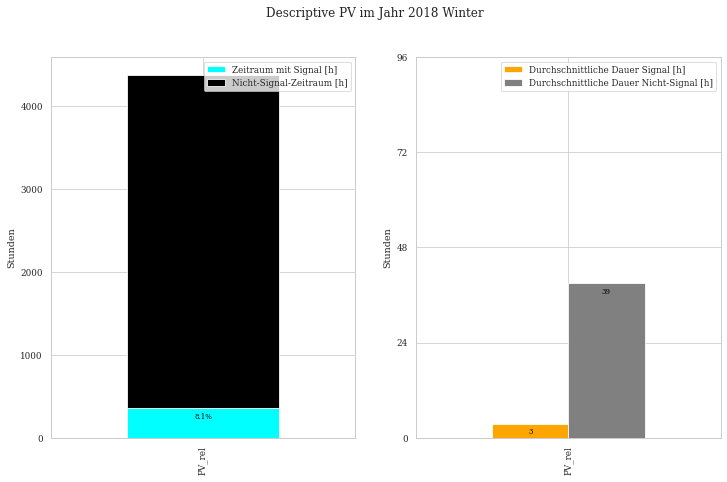

In [48]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
desc_PV_w.loc[colsstep_PV][["Zeitraum mit Signal [h]","Nicht-Signal-Zeitraum [h]"]]\
    .plot(kind="bar",color=["cyan", "black"], stacked=True, ax = ax[0]).set(ylabel="Stunden")
desc_PV_w.loc[colsstep_PV][["Durchschnittliche Dauer Signal [h]","Durchschnittliche Dauer Nicht-Signal [h]"]]\
    .plot(kind="bar",color=["orange", "grey"], stacked=False, ax = ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
     ax[0].annotate("{:.1f}%" .format(p.get_height()*100/len(df_PV_sign_w)), (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() -5), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
      ax[1].annotate("{:.0f}" .format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive PV im Jahr {em_year} Winter', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_PV_{em_year}_winter.png", dpi=300, bbox_inches='tight')

In [49]:
df_PV_step_s = pd.DataFrame()
df_PV_not_s = pd.DataFrame()

for c in df_PV_sign_s.columns:
    df_PV_step_s[c] = df_PV_sign_s[c].shift(1).ne(df_PV_sign_s[c]).where(df_PV_sign_s[c] == 1).cumsum()
    df_PV_not_s[c] = df_PV_sign_s[c].shift(1).ne(df_PV_sign_s[c]).where(df_PV_sign_s[c] == -1).cumsum()
df_PV_step_s.iloc[0, :] = 0

In [50]:
desc_PV_s = pd.DataFrame()
desc_PV_s["Zeitraum mit Signal [h]"] = df_PV_sign_s.where(df_PV_sign_s > 0).sum()
desc_PV_s["Nicht-Signal-Zeitraum [h]"] = len(df_PV_sign_s) - desc_PV_s["Zeitraum mit Signal [h]"]
desc_PV_s["Anzahl Signal-Perioden"] = df_PV_step_s.max()
desc_PV_s["Durchschnittliche Dauer Signal [h]"] = (
            desc_PV_s["Zeitraum mit Signal [h]"] / desc_PV_s["Anzahl Signal-Perioden"])
desc_PV_s["Durchschnittliche Dauer Nicht-Signal [h]"] = desc_PV_s["Nicht-Signal-Zeitraum [h]"] / desc_PV_s[
    "Anzahl Signal-Perioden"]

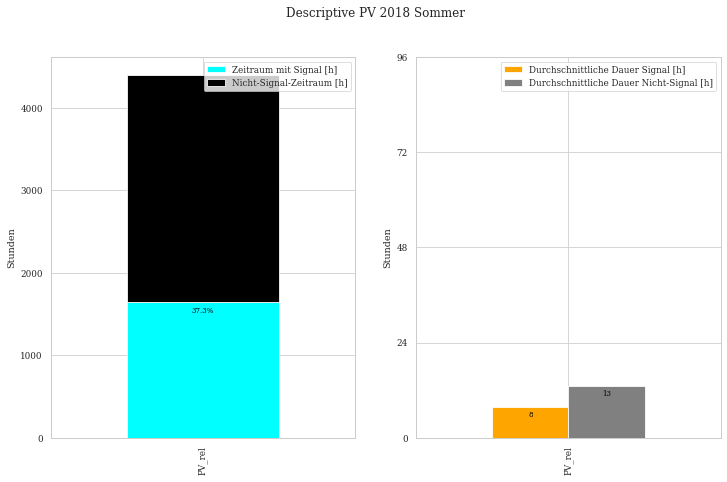

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
desc_PV_s.loc[colsstep_PV][["Zeitraum mit Signal [h]", "Nicht-Signal-Zeitraum [h]"]].plot(kind="bar", color=["cyan", "black"], stacked=True, ax=ax[0]).set(ylabel="Stunden")
desc_PV_s.loc[colsstep_PV][["Durchschnittliche Dauer Signal [h]", "Durchschnittliche Dauer Nicht-Signal [h]"]].plot(kind="bar", color=["orange", "grey"], stacked=False, ax=ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
    ax[0].annotate("{:.1f}%".format(p.get_height() * 100 / len(df_PV_sign_s)),
                   (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() - 5), ha='center', va='center',
                   fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
    ax[1].annotate("{:.0f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                   va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive PV {em_year} Sommer', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_PV_{em_year}_sommer.png", dpi=300, bbox_inches='tight')

In [52]:
# Wie viel % von Wind und PV wird bei beiden Fällen direkt verbraucht und wie viele wird eingespeist???
# a barchartokba kellene mindig mindkettö , hogy látni lehessen a különbséget...

## Stunde-Skalierung

Über acht 3-stündliche Werte wird ein spezifische Tagesverlauf generiert und für das ganze Jahr ...

In [53]:

# apply transform
import FLUCCOplus.transform as traffo
import os

if not os.path.exists("../Data/interim"):
        os.makedirs("../Data/interim")

hscale = 24
p_day = np.array([1.1, 1.2, 2.2, 1.6, 1.6, 1.4, 1.9, 1.2])
day = traffo.transform(p_day, hour_scale=hscale)

x = np.arange(0, hscale, hscale/len(p_day))
xh = np.arange(0,8760,1)

plt.plot(xh[:hscale*2], day[:hscale*2], "r")
plt.plot(x[:hscale*2], p_day[:hscale*2], "bo")

#np.savetxt(config.DATA_INTERIM / Path("tagesverlauf.csv"), day, format("%2.4f"))
day

TypeError: 'type' object is not subscriptable

In [ ]:
day.sum()

Über acht Skalierfaktor wird ein "Skalierverlauf" für das ganze Jahr generiert...

In [ ]:
import numpy as np
p_day_scaler = [1, 1, 1.4, 1.3, 0.8, 0.7, 0.9, 1] # hours are in 3-hour-steps
day_scaler = traffo.transform(p_day_scaler, hour_scale=hscale)


x = np.arange(0, hscale, hscale/len(p_day_scaler))
xh = np.arange(0,8760,1)
plt.plot(xh[:hscale*2], day_scaler[:hscale*2], "orange")
plt.plot(x[:hscale*2], p_day_scaler[:hscale*2], "co")

day_scaler

Der spezifische Jahresverlauf wird mit dem "Skalierverlauf" multipliziert...

In [ ]:
scaled_day = np.multiply(day,day_scaler)
scaled_day

In [ ]:
scaled_day.sum()

In [ ]:
x = np.arange(0, hscale, hscale/len(p_day_scaler))
xh = np.arange(0,8760,1)

plt.plot(xh[:hscale*2], day[:hscale*2], "r")

plt.plot(xh[:hscale*2], day_scaler[:hscale*2], "y:")

plt.plot(xh[:hscale*2], scaled_day[:hscale*2], "magenta", linewidth=2.0)
plt.legend(['Defaultwert', 'Skalierfaktor', 'Skalierte Werte'])
plt.plot(x[:hscale*2], p_day[:hscale*2], "bo")
plt.plot(x[:hscale*2], p_day_scaler[:hscale*2], "co")
plt.savefig('../Data/interim/Default_skaliert.png', dpi=300)

Skalierfaktor zu dem Zielwert wird ermittelt...

In [ ]:
target_value=s.TSD.Strombedarf.sum()/1000
target_value

In [ ]:
scale_factor = target_value / scaled_day.sum()
scale_factor

Die 3-stündliche Werte werden hochskaliert...

In [ ]:
p_day_to_target = p_day * scale_factor
p_day_to_target

und der Jahresverlauf wird durch das Tagesprofil generiert...

In [ ]:
day_to_target = traffo.transform(p_day_to_target, hour_scale=8760)
pd.DataFrame(day_to_target).plot()

In [ ]:
df_scaled = s.TSD["Strombedarf"] * day_to_target
df_scaled.plot()

In [ ]:

x = np.arange(0, hscale, hscale/len(p_day_to_target))
xh = np.arange(0,8760,1)

plt.plot(xh[:hscale*2], day_to_target[:hscale*2], "purple")
plt.plot(x[:hscale*2], p_day_to_target[:hscale*2], "go")

In [ ]:
x = np.arange(0, hscale, hscale/len(p_day_to_target))
xh = np.arange(0,8760,1)

plt.plot(xh[:hscale*2], day[:hscale*2], "r")
plt.plot(xh[:hscale*2], day_to_target[:hscale*2], "purple")
plt.legend(['Defaultwert', 'Targetwert'])
#plt.plot(x[:hscale*2], p_day[:hscale*2], "bo")
#plt.plot(x[:hscale*2], p_day_to_target[:hscale*2], "go")
plt.savefig('../Data/interim/Default_and_Targetvalue.png', dpi=300)

Der skalierte Jahresverlauf wird mit dem Skalierverlauf multipliziert...

In [ ]:
scaled_day_to_target = np.multiply(day_to_target,day_scaler)
scaled_day_to_target

In [ ]:
scaled_day_to_target.sum()

In [ ]:
target_value

In [ ]:
x = np.arange(0, hscale, hscale/len(p_day_to_target))
xh = np.arange(0,8760,1)

plt.plot(xh[:hscale*2], day_to_target[:hscale*2], "r")
plt.plot(xh[:hscale*2], scaled_day_to_target[:hscale*2], "orange", linewidth=2.0)

plt.legend(['Zielwert', 'skalierte Zielwert'])
plt.plot(x[:hscale*2], p_day_to_target[:hscale*2], "bo")
plt.savefig('../Data/interim/skalierte_Default_and_Targetvalue.png', dpi=300)

In [ ]:
import panel as pn
import panel.widgets as pnw
from matplotlib.figure import Figure

def scaler_plot(scaler, support_points, hour_scale, view_scale=2):
    """
    scaler: zeitreihe (8760)
    
    """
    p, h = support_points, hour_scale

    x = np.arange(0, h, h/len(p))
    xh = np.arange(0,8760,1)

    fig = Figure()
    ax = fig.add_subplot()
    a, b = 0, int(h*view_scale)
    ax.plot(x[a:b], p[a:b], "bo")
    ax.plot(xh[a:b], scaler[a:b], "r")
    return fig

scaler_plot(day,p_day, 24)

In [ ]:
#params
N = 12 # muss eigentlich anzahl der skalierungswerte sein
zyklus = 24 #h zyklus
timeseries = df_scaled


points = [pnw.FloatSlider(name='', value=1.0, start=0., end=3., step=0.05) for i in range(N)]
#points = np.array(p_day_scaler)
#points = [pnw.FloatSlider(name='', value=1.0, start=0., end=3., step=0.05) for i in range(N)]
@pn.depends(*points)
def reactive_scalar(*points):
    p = np.array(p_day_scaler)
    transformed_timeseries = timeseries * traffo.transform(p)
    return scaler_plot(transformed_timeseries, points, zyklus)

widgets   = pn.Column("<br>\n# Reactive Scaler")
sliders = pn.Column(widgets, *points)
dashboard = pn.Row(sliders, reactive_scalar)

pn.extension()
pn.interact()
dashboard

## Monate-Skalierung

In [ ]:
type(day_to_target)

In [ ]:
month_values = np.divide(day_to_target,730)
for i in range(12):
    month_values[i] = day_to_target


In [ ]:
# scale to fit targetsum

# get load
# apply transform
#     ecars (non dsm)
#
# scale to fit targetsum

# em scenario residual load report